# scCODA and tascCODA - Case study

This notebook is a reproduction of a case study with scCODA and tascCODA that was carried out as an example analysis for the [single-cell best practices book (Heumos, Schaar et al., 2022)](https://www.sc-best-practices.org/preamble.html).

## Setup

In [1]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import matplotlib.pyplot as plt
import pertpy as pt
import scanpy as sc

## Dataset

The analysis is carried out on the [Haber et al., 2017](https://www.nature.com/articles/nature24489) dataset that was also used in the scCODA quickstart tutorial.

We first import this dataset.

**Note:** If you’re dealing with a continuous covariate, make sure to normalize it (e.g. using min-max normalization) before passing it to scCODA.

In [2]:
haber_cells = pt.dt.haber_2017_regions()

sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    haber_cells,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="cell_label",
    sample_identifier="batch",
    covariate_obs=["condition"],
)
print(sccoda_data)

MuData object with n_obs × n_vars = 9852 × 15223
  2 modalities
    rna:	9842 x 15215
      obs:	'batch', 'barcode', 'condition', 'cell_label'
    coda:	10 x 8
      obs:	'condition'
      var:	'n_cells'


## With labeled clusters

[scCODA](https://sccoda.readthedocs.io/en/latest) belongs to the family of tools that require pre-defined clusters, most commony cell types, to statistically derive changes in composition.
Inspired by methods for compositional analysis of microbiome data, scCODA proposes a Bayesian approach to address the low replicate issue as commonly encountered in single-cell analysis{cite}`Büttner2021`.
It models cell-type counts using a hierarchical Dirichlet-Multinomial model, which accounts for uncertainty in cell-type proportions and the negative correlative bias via joint modeling of all measured cell-type proportions. To ensure a uniquely identifiable solution and easy interpretability, the reference in scCODA is chosen to be a specific cell type. Hence, any detected compositional changes by scCODA always have to be viewed in relation to the selected reference.

However, scCODA assumes a log-linear relationship between covariates and cell abundance, which may not always reflect the underlying biological processes when using continuous covariates.
A further limitation of scCODA is the inability to infer correlation structures among cell compositions beyond compositional effects. Furthermore, scCODA only models shifts in mean abundance, but does not detect changes in response variability

To get an overview of the cell type distributions across conditions we can use scCODA's `boxplots`.
To get an even better understanding of how the data is distributed, the red dots show the actual data points.

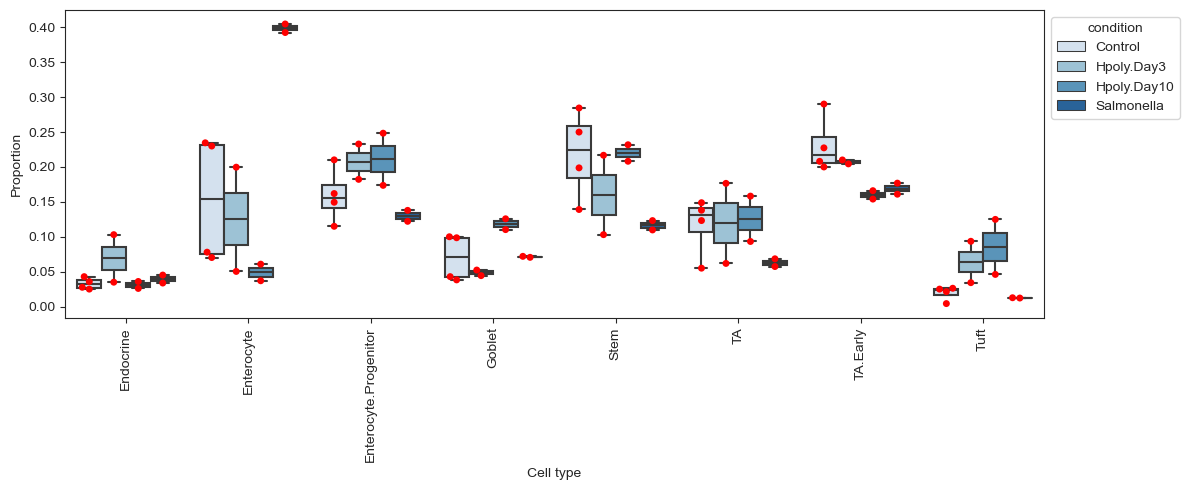

In [3]:
pt.pl.coda.boxplots(
    sccoda_data,
    modality_key="coda",
    feature_name="condition",
    figsize=(12, 5),
    add_dots=True,
    args_swarmplot={"palette": ["red"]},
)
plt.show()

The boxplots highlight some differences in the distributions of the cell types. Clearly noticeable is the high proportion of enterocytes for the Salmonella condition.
However, other cell types such as transit-amplifying (TA) cells also show stark differences in abundance for the Salmonella condition compared to control. Whether any of these differences are statistically significant has to be properly evaluated.

An alternative visualization is a stacked barplot as provided by scCODA.
This visualization nicely displays the characteristics of compositional data: If we compare the Control and Salmonella groups, we can see that the proportion of Enterocytes greatly increases in the infected mice.
Since the data is proportional, this leads to a decreased share of all other cell types to fulfil the sum-to-one constraint.

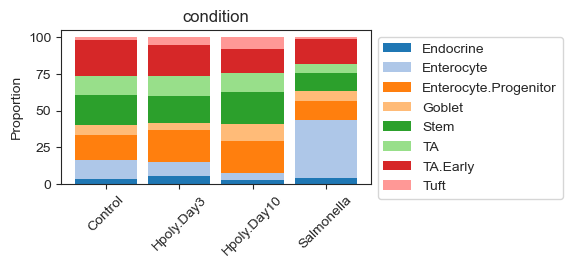

In [4]:
pt.pl.coda.stacked_barplot(sccoda_data, modality_key="coda", feature_name="condition", figsize=(4, 2))
plt.show()

scCODA requires two major parameters beyond the cell count AnnData object: A formula and a reference cell type.
The formula describes the covariates, which are specified using the [R-style](https://www.statsmodels.org/stable/example_formulas.html).
In our case we specify the condition as the only covariate. Since it is a discrete covariate with four levels (control and three disease states), this models a comparison of each state with the other samples.
If we wanted to model multiple covariates at once, simply adding them in the formula (i.e. `formula = "covariate_1 + covariate_2"`) is enough.
As mentioned above, scCODA requires a reference cell type to compare against, which is believed to be unchanged by the covariates.
scCODA can either automatically select an appropriate cell type as reference, which is a cell type that has nearly constant relative abundance over all samples, or be run with a user specified reference cell type.
Here we set Endocrine cells as the reference since visually their abundance seems to be rather constant.
An alternative to setting a reference cell type manually is to set the `reference_cell_type` to `"automatic"` which will force scCODA to select a suitable reference cell type itself.
If the choice of reference cell type is unclear, we recommend using this option to get an indicator or even a final selection.

In [5]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="condition",
    reference_cell_type="Endocrine",
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda", rng_key=1234)

sample: 100%|██████████| 11000/11000 [01:19<00:00, 139.23it/s, 255 steps of size 1.88e-02. acc. prob=0.83]


In [6]:
sccoda_data["coda"].varm["effect_df_condition[T.Salmonella]"]

,Final Parameter,HDI 3%,HDI 97%,SD,Inclusion probability,Expected Sample,log2-fold change
Cell Type,,,,,,,
Endocrine,0.000000,0.000,0.000,0.000,0.0000,32.531769,-0.526704
Enterocyte,1.545717,1.026,2.094,0.279,1.0000,382.578536,1.703294
Enterocyte.Progenitor,0.000000,-0.505,0.555,0.148,0.2895,126.117894,-0.526704
Goblet,0.000000,-0.337,0.994,0.283,0.4325,52.890151,-0.526704
Stem,0.000000,-0.728,0.307,0.176,0.3077,135.533269,-0.526704
TA,0.000000,-0.841,0.397,0.217,0.3379,79.060797,-0.526704
TA.Early,0.000000,-0.385,0.602,0.153,0.3109,152.355581,-0.526704
Tuft,0.000000,-1.319,0.539,0.359,0.4126,23.132004,-0.526704


In [7]:
sccoda_model.set_fdr(sccoda_data, modality_key="coda", est_fdr=0.2)

In [8]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda")

Covariate                 Cell Type            
condition[T.Hpoly.Day3]   Endocrine                False
                          Enterocyte               False
                          Enterocyte.Progenitor    False
                          Goblet                   False
                          Stem                     False
                          TA                       False
                          TA.Early                 False
                          Tuft                     False
condition[T.Hpoly.Day10]  Endocrine                False
                          Enterocyte                True
                          Enterocyte.Progenitor    False
                          Goblet                   False
                          Stem                     False
                          TA                       False
                          TA.Early                 False
                          Tuft                      True
condition[T.Salmonella]   Endocrine     

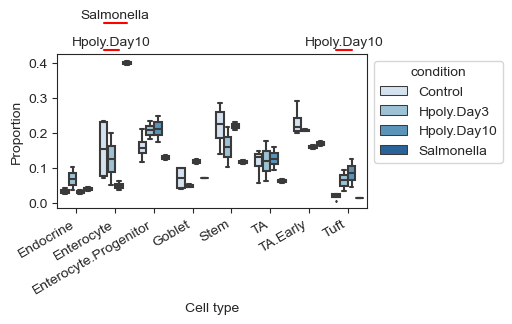

In [9]:
ax = pt.pl.coda.boxplots(
    sccoda_data,
    feature_name="condition",
    modality_key="coda",
    draw_effects=True,
    model=sccoda_model,
    figsize=(4, 2),
)
plt.xticks(rotation=30, ha="right")
plt.show()

We can now easily filter by the cell types that had credible changes and show their log fold changes.

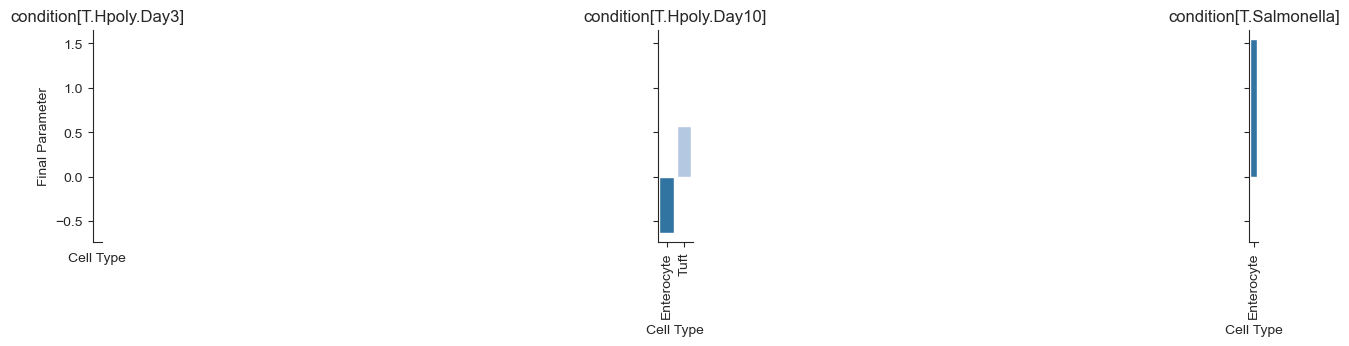

In [10]:
pt.pl.coda.effects_barplot(
    sccoda_data,
    modality_key="coda",
    covariates="condition",
    parameter="Final Parameter",
)
plt.show()

The plots nicely show the significant and credible effects of conditions on the cell types. These effects largely agree with the findings in the Haber paper, who used a non-compositional Poisson regression model their findings:

1. "After Salmonella infection, the frequency of mature enterocytes increased substantially."
2. "Heligmosomoides polygyrus caused an increase in tuft cells and a decrease in Enterocytes."

Readers familiar with the original publication may wonder why the model used by Haber et al. found more significant effects than scCODA, for example a decrease in Stem and Transit-Amplifying cells in the case of Salmonella infection. To explain this discrepancy, remember that cell count data is compositional and therefore an increase in the relative abundance of one cell type will lead to a decrease in the relative abundance of all other cell types.
Due to the stark increase of Enterocytes in the small intestinal epithelium of Salmonella-infected mice, all other cell types appear to decrease, even though this shift is only caused by the compositional properties of the data. While the original (univariate) Poisson regression model will pick up these likely false positive effects, scCODA is able to account for the compositionality of the data and therefore does not fall into this trap.

## With labeled clusters and hierarchical structure

In addition to the abundance of each cell type, a typical single-cell dataset also contains information about the similarity of the different cells in the form of a tree-based hierarchical ordering. These hierarchies can either be determined automatically via clustering of the gene expression (which is usually done to discover the clusters of cells that belong to the same cell type), or through biologically informed hierarchies like cell lineages.
[tascCODA](https://tasccoda.readthedocs.io/en/latest/) is an extension of scCODA that integrates hierarchical information and experimental covariate data into the generative modeling of compositional count data{cite}`Ostner2021`. This is especially beneficial for cell atlassing efforts with increased resolution.

At its core, it uses almost the same Dirichlet-Multinomial setup as scCODA, but extends the model, such that effects on sets of cell types, which are defined as internal nodes in the tree structure.

In [11]:
import schist

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

To use tascCODA, we first have to define a hierarchical ordering of the cell types. One possible hierarchical clustering uses the eight cell types and orders them by their similarity (pearson correlation) in the PCA representation with `sc.tl.dendrogram`.
Since this structure is very simple in our data and will therefore not give us many new insights, we want to have a more complex clustering. One recent method to get such clusters, is the [schist](https://github.com/dawe/schist) package, which uses a nested stochastic block model that clusters the cell population at different resolution levels. Running the method with standard settings takes some time (~15 minutes on our data), and gives us an assignment of each cell to a hierarchical clustering in `adata.obs`.
First, we need to define a distance measure between the cells through a PCA embedding:

In [12]:
adata = haber_cells.copy()
# use logcounts to calculate PCA and neighbors
adata.layers["counts"] = adata.X.copy()
adata.layers["logcounts"] = sc.pp.log1p(adata.layers["counts"]).copy()
adata.X = adata.layers["logcounts"].copy()
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30, random_state=1234)

# Calculate UMAP for visualization purposes
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


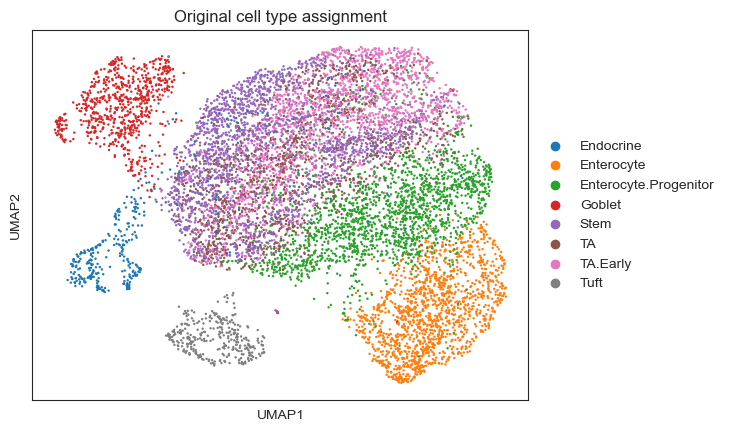

In [13]:
sc.pl.umap(adata, color=["cell_label"], show=False)
plt.title("Original cell type assignment")
plt.show()

We now run the clustering with `schist`:

In [14]:
schist.inference.nested_model(adata, samples=100, random_seed=5678)
adata.obs

,batch,barcode,condition,cell_label,nsbm_level_0,nsbm_level_1,nsbm_level_2,nsbm_level_3,nsbm_level_4,nsbm_level_5
index,,,,,,,,,,
B1_AAACATACCACAAC_Control_Enterocyte.Progenitor,B1,AAACATACCACAAC,Control,Enterocyte.Progenitor,0,0,0,0,0,0
B1_AAACGCACGAGGAC_Control_Stem,B1,AAACGCACGAGGAC,Control,Stem,5,5,7,1,1,0
B1_AAACGCACTAGCCA_Control_Stem,B1,AAACGCACTAGCCA,Control,Stem,107,2,1,1,1,0
B1_AAACGCACTGTCCC_Control_Stem,B1,AAACGCACTGTCCC,Control,Stem,130,3,7,1,1,0
B1_AAACTTGACCACCT_Control_Enterocyte.Progenitor,B1,AAACTTGACCACCT,Control,Enterocyte.Progenitor,3,17,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
B10_TTTCACGACAAGCT_Salmonella_TA,B10,TTTCACGACAAGCT,Salmonella,TA,15,39,7,1,1,0
B10_TTTCAGTGAGGCGA_Salmonella_Enterocyte,B10,TTTCAGTGAGGCGA,Salmonella,Enterocyte,144,16,11,1,1,0
B10_TTTCAGTGCGACAT_Salmonella_Stem,B10,TTTCAGTGCGACAT,Salmonella,Stem,110,1,1,1,1,0


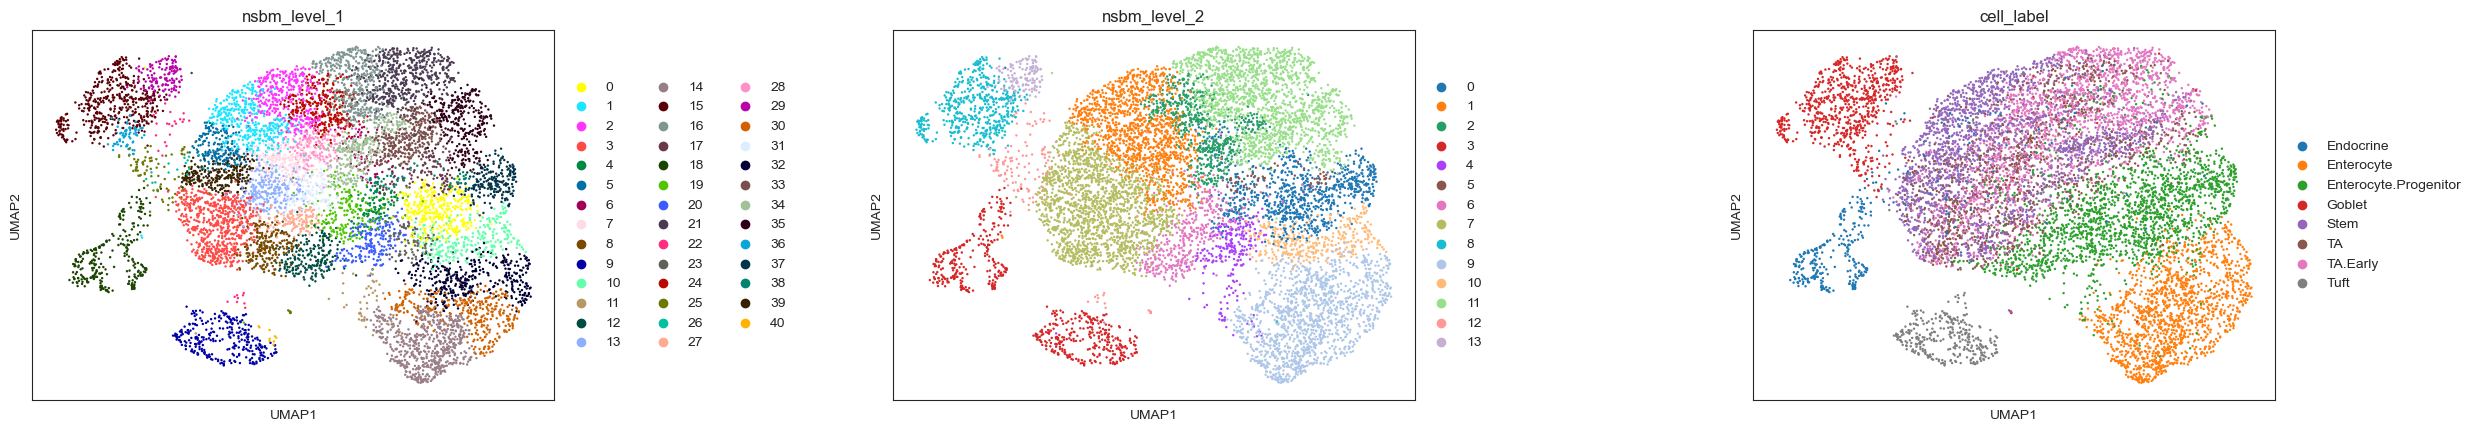

In [15]:
sc.pl.umap(adata, color=["nsbm_level_1", "nsbm_level_2", "cell_label"], ncols=3, wspace=0.5)

Now, we convert our cell-level data to sample-level data and create the tree. To get some clusters that are not too small, we cut the tree before the last level by leaving out `"nsbm_level_0"`.

In [16]:
tasccoda_model = pt.tl.Tasccoda()
tasccoda_data = tasccoda_model.load(
    adata,
    type="cell_level",
    cell_type_identifier="nsbm_level_1",
    sample_identifier="batch",
    covariate_obs=["condition"],
    levels_orig=["nsbm_level_4", "nsbm_level_3", "nsbm_level_2", "nsbm_level_1"],
    add_level_name=True,
)
tasccoda_data

MuData object with n_obs × n_vars = 9852 × 15256
  2 modalities
    rna:	9842 x 15215
      obs:	'batch', 'barcode', 'condition', 'cell_label', 'nsbm_level_0', 'nsbm_level_1', 'nsbm_level_2', 'nsbm_level_3', 'nsbm_level_4', 'nsbm_level_5'
      uns:	'neighbors', 'umap', 'cell_label_colors', 'schist', 'nsbm_level_1_colors', 'nsbm_level_2_colors'
      obsm:	'X_pca', 'X_umap', 'CM_nsbm_level_0', 'CM_nsbm_level_1', 'CM_nsbm_level_2', 'CM_nsbm_level_3', 'CM_nsbm_level_4', 'CM_nsbm_level_5'
      layers:	'counts', 'logcounts'
      obsp:	'distances', 'connectivities'
    coda:	10 x 41
      obs:	'condition'
      var:	'n_cells'
      uns:	'tree'

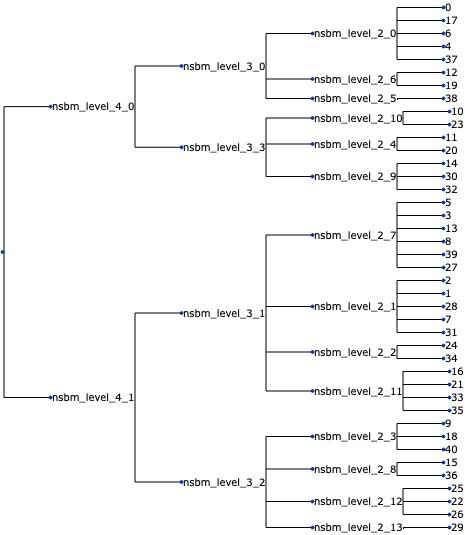

In [17]:
pt.pl.coda.draw_tree(tasccoda_data)

The model setup and execution in tascCODA works analogous to scCODA, and also the free parameters for the reference and the formula are the same.
Additionally, we can adjust the tree aggregation and model selection via the parameters `phi` and `lambda_1` in the `pen_args` argument (see {cite}Ostner2021 for more information).
Here, we use an unbiased setting `phi=0` and a model selection that is slightly less strict than the default with `lambda_1=3.5`. We use cluster 18 as our reference, since it is almost identical to the set of Endocrine cells.

In [18]:
tasccoda_model.prepare(
    tasccoda_data,
    modality_key="coda",
    reference_cell_type="18",
    formula="condition",
    pen_args={"phi": 0, "lambda_1": 3.5},
    tree_key="tree",
)

Zero counts encountered in data! Added a pseudocount of 0.5.

MuData object with n_obs × n_vars = 9852 × 15256
  2 modalities
    rna:	9842 x 15215
      obs:	'batch', 'barcode', 'condition', 'cell_label', 'nsbm_level_0', 'nsbm_level_1', 'nsbm_level_2', 'nsbm_level_3', 'nsbm_level_4', 'nsbm_level_5'
      uns:	'neighbors', 'umap', 'cell_label_colors', 'schist', 'nsbm_level_1_colors', 'nsbm_level_2_colors'
      obsm:	'X_pca', 'X_umap', 'CM_nsbm_level_0', 'CM_nsbm_level_1', 'CM_nsbm_level_2', 'CM_nsbm_level_3', 'CM_nsbm_level_4', 'CM_nsbm_level_5'
      layers:	'counts', 'logcounts'
      obsp:	'distances', 'connectivities'
    coda:	10 x 41
      obs:	'condition'
      var:	'n_cells'
      uns:	'tree', 'scCODA_params'
      obsm:	'covariate_matrix', 'sample_counts'

In [19]:
tasccoda_model.run_nuts(tasccoda_data, modality_key="coda", rng_key=1234, num_samples=10000, num_warmup=1000)

sample: 100%|██████████| 11000/11000 [05:06<00:00, 35.87it/s, 127 steps of size 3.38e-02. acc. prob=0.95]


In [20]:
tasccoda_model.summary(tasccoda_data, modality_key="coda")

                                          Compositional Analysis summary                                           
┌────────────────────────────────────────────┬────────────────────────────────────────────────────────────────────┐
│ Name                                       │ Value                                                              │
├────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────┤
│ Data                                       │ Data: 10 samples, 41 cell types                                    │
│ Reference cell type                        │ 18                                                                 │
│ Formula                                    │ condition                                                          │
└────────────────────────────────────────────┴────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            Final Parameter  Expected Sample                                                                     │
│ Cell Type                                                                                                       │
│ 0               1.526           52.949                                                                          │
│ 1               1.694           62.635                                                                          │
│ 2               1.575           55.608                                                                          │
│ 3               1.813           70.550                                                                          │
│ 4               0.044           12.029                                                                          │
│ 5               0.555           20.052                                                                          │
│ 6              -0.005           11.454                                                                          │
│ 7               0.751           24.394                                                                          │
│ 8              -0.171            9.702                                                                          │
│ 9               0.706           23.320                                                                          │
│ 10              0.898           28.257                                                                          │
│ 11             -0.289            8.622                                                                          │
│ 12              0.462           18.271                                                                          │
│ 13              0.974           30.488                                                                          │
│ 14              0.948           29.705                                                                          │
│ 15              1.355           44.627                                                                          │
│ 16              1.657           60.360                                                                          │
│ 17              0.460           18.235                                                                          │
│ 18              0.983           30.763                                                                          │
│ 19              0.401           17.190                                                                          │
│ 20              0.308           15.663                                                                          │
│ 21              1.943           80.345                                                                          │
│ 22             -0.604            6.292                                                                          │
│ 23              0.009           11.615                                                                          │
│ 24              1.418           47.528                                                                          │
│ 25             -0.003           11.477                                                                          │
│ 26             -0.892            4.718                                                                          │
│ 27             -0.120           10.210                                                                          │
│ 28              0.618           21.356                                                                          │
│ 29              0.277           15.185                

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                   Effect  Expected Sample  log2-fold change                                     │
│ Covariate              Cell Type                                                                                │
│ conditionT.Hpoly.Day3  0           0.000      52.849            -0.003                                          │
│                        1           0.000      62.517            -0.003                                          │
│                        2           0.000      55.503            -0.003                                          │
│                        3           0.366     101.538             0.525                                          │
│                        4           0.000      12.006            -0.003                                          │
│                        5           0.366      28.859             0.525                                          │
│                        6           0.000      11.432            -0.003                                          │
│                        7           0.000      24.348            -0.003                                          │
│                        8           0.366      13.963             0.525                                          │
│                        9           0.000      23.276            -0.003                                          │
│                        10          0.000      28.203            -0.003                                          │
│                        11          0.000       8.606            -0.003                                          │
│                        12          0.000      18.237            -0.003                                          │
│                        13          0.366      43.879             0.525                                          │
│                        14          0.000      29.649            -0.003                                          │
│                        15          0.000      44.542            -0.003                                          │
│                        16         -0.641      31.736            -0.927                                          │
│                        17          0.000      18.200            -0.003                                          │
│                        18          0.000      30.705            -0.003                                          │
│                        19          0.000      17.158            -0.003                                          │
│                        20          0.000      15.634            -0.003                                          │
│                        21         -0.641      42.243            -0.927                                          │
│                        22          0.000       6.280            -0.003                                          │
│                        23          0.000      11.593            -0.003                                          │
│                        24          0.000      47.439            -0.003                                          │
│                        25          0.000      11.455            -0.003                                          │
│                        26          0.000       4.709            -0.003                                          │
│                        27          0.366      14.694             0.525                                          │
│                        28          0.000      21.316            -0.003                                          │
│                        29          0.000      15.157  

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Nodes                                                                                                           │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Covariate=condition[T.Hpoly.Day10]_node                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                  Final Parameter  Is credible                                                                   │
│ Node                                                                                                            │
│ nsbm_level_4_0       -0.27            True                                                                      │
│ nsbm_level_4_1        0.00           False                                                                      │
│ nsbm_level_3_0        0.00           False                                                                      │
│ nsbm_level_3_3        0.00           False                                                                      │
│ nsbm_level_3_1       -1.77            True                                                                      │
│ nsbm_level_3_2        0.00           False                                                                      │
│ nsbm_level_2_0       -0.88            True                                                                      │
│ nsbm_level_2_6        0.00           False                                                                      │
│ 38                    0.00           False                                                                      │
│ nsbm_level_2_10       0.00           False                                                                      │
│ nsbm_level_2_4        0.00           False                                                                      │
│ nsbm_level_2_9        0.00           False                                                                      │
│ nsbm_level_2_7        0.00           False                                                                      │
│ nsbm_level_2_1        0.00           False                                                                      │
│ nsbm_level_2_2        0.00           False                                                                      │
│ nsbm_level_2_11       0.00           False                                                                      │
│ nsbm_level_2_3        0.00           False                                                                      │
│ nsbm_level_2_8        0.00           False                                                                      │
│ nsbm_level_2_12       0.00           False                                                                      │
│ 29                    0.00           False                                                                      │
│ 0                    -0.43            True                                                                      │
│ 17                    0.00           False                                                                      │
│ 6                     0.00           False                                                                      │
│ 4                     0.00           False                                                                      │
│ 37                    0.29            True                                                                      │
│ 12                    0.00           False                                                                      │
│ 19                    0.00           False                                                                      │
│ 10                    0.00           False            

Again, the acceptance probability is right around the desired value of 0.85 for tascCODA, indicating no apparent problems with the optimization.

The result from tascCODA should first and foremost be interpreted as effects on the nodes of the tree. A nonzero parameter on a node means that the aggregated count of all cell types under that node changes significantly.
We can easily visualize this in a tree plot for each of the three disease states. Blue circles indicate an increase, red circles a decrease:

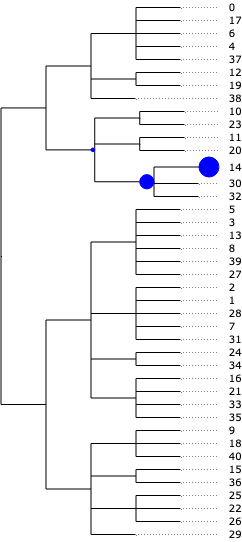

In [21]:
pt.pl.coda.draw_effects(
    tasccoda_data,
    modality_key="coda",
    tree="tree",
    covariate="condition[T.Salmonella]",
    show_leaf_effects=False,
    show_legend=False,
)

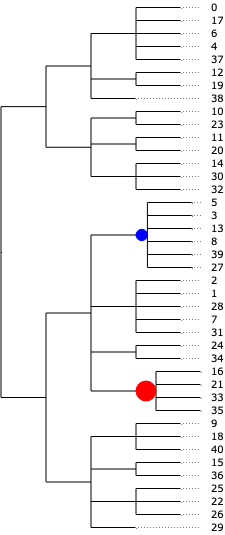

In [25]:
pt.pl.coda.draw_effects(
    tasccoda_data,
    modality_key="coda",
    tree="tree",
    covariate="condition[T.Hpoly.Day3]",
    show_leaf_effects=False,
    show_legend=False,
)

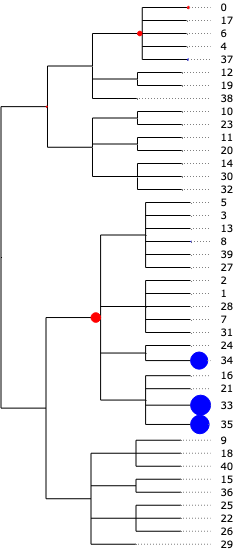

In [26]:
pt.pl.coda.draw_effects(
    tasccoda_data,
    modality_key="coda",
    tree="tree",
    covariate="condition[T.Hpoly.Day10]",
    show_leaf_effects=False,
    show_legend=False,
)

Alternatively, effects on internal nodes can also be translated through the tree onto the cell type level, allowing for a calculation of log-fold changes like in scCODA.
To visualize the log-fold changes of the cell types, we do the same plots as for scCODA.

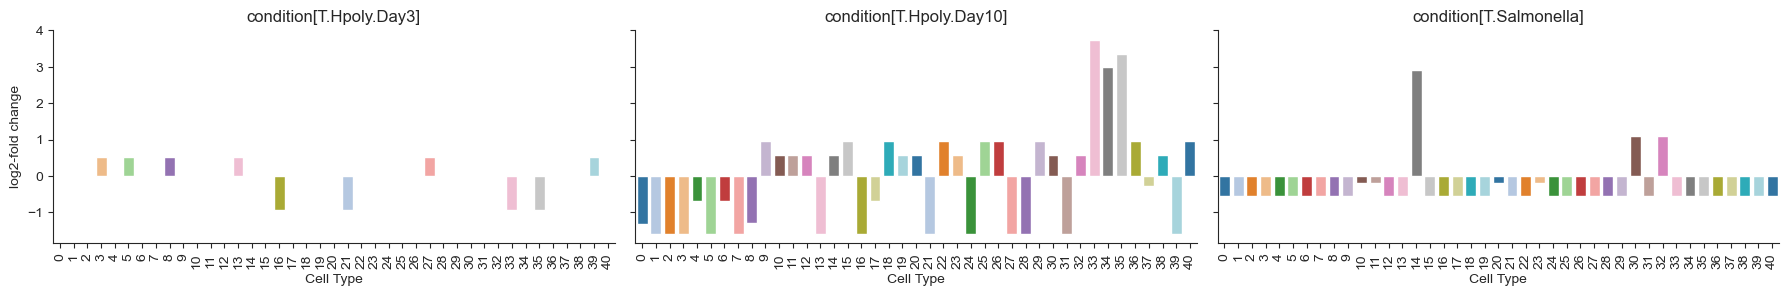

In [22]:
pt.pl.coda.effects_barplot(tasccoda_data, modality_key="coda", covariates="condition")

Another insightful representation can be gained by plotting the effect sizes for each condition on the UMAP embedding, and comparing it to the cell type assignments:

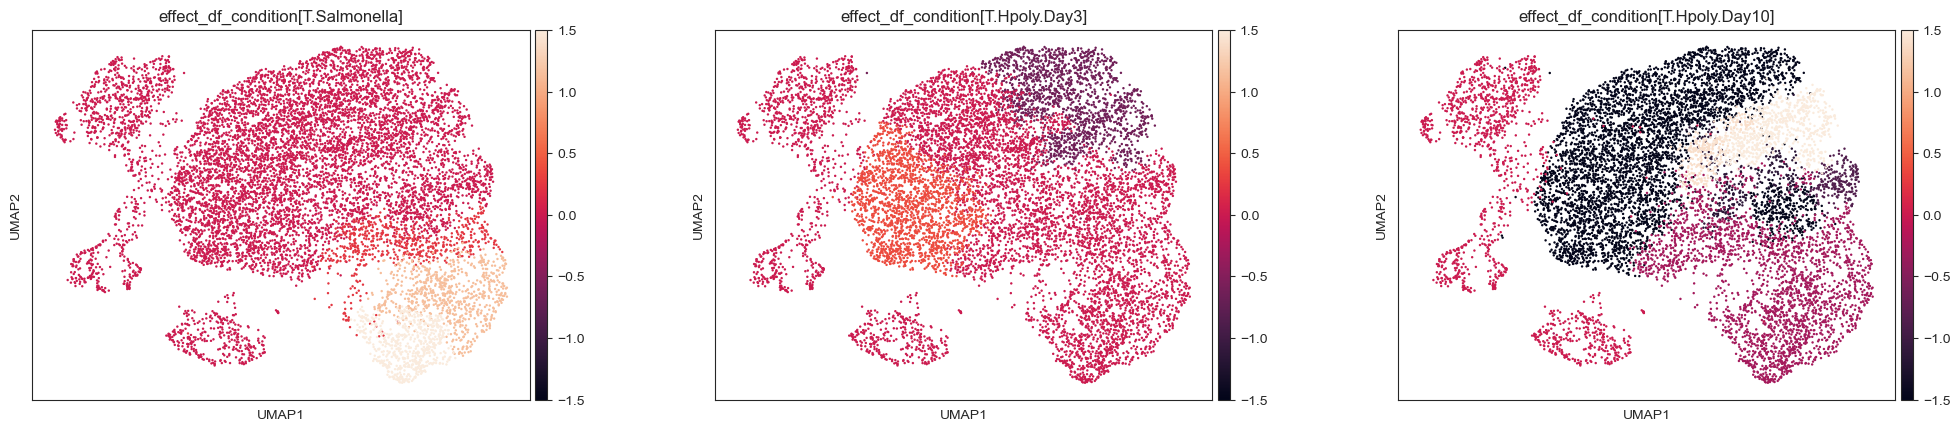

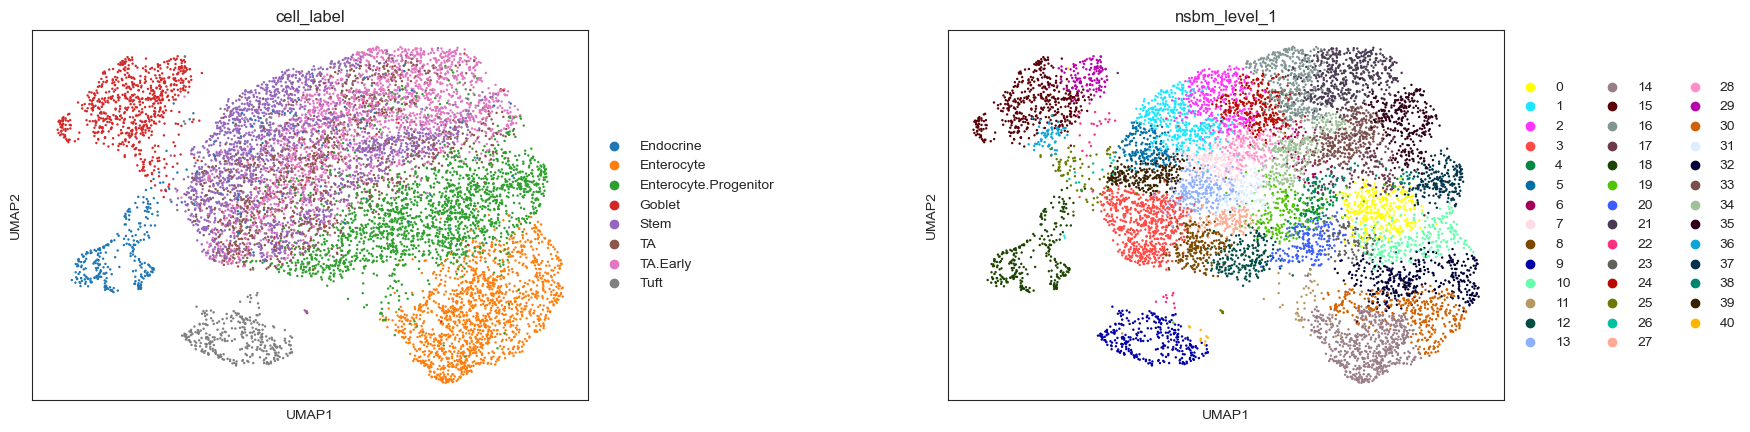

In [24]:
kwargs = {"ncols": 3, "wspace": 0.25, "vcenter": 0, "vmax": 1.5, "vmin": -1.5}
pt.pl.coda.effects_umap(
    tasccoda_data,
    effect_name=[
        "effect_df_condition[T.Salmonella]",
        "effect_df_condition[T.Hpoly.Day3]",
        "effect_df_condition[T.Hpoly.Day10]",
    ],
    cluster_key="nsbm_level_1",
    **kwargs,
)
sc.pl.umap(tasccoda_data["rna"], color=["cell_label", "nsbm_level_1"], ncols=2, wspace=0.5)

The results are very similar to scCODA's findings:
- For the Salmonella infection, we get an aggregated increase in clusters that approximately represent Enterocytes in the cell type clustering. This increase is even stronger for cluster 14, as indicated by the additional positive effect on the leaf level
- For the Heligmosomoides polygyrus infection, we get almost no credible changes after 3 days. After 10 days, we pick up decreases in clusters that contain Stem- and transit-amplifying cells, as well as a less strong decrease of Enterocytes and Enterocyte progenitors, which was also picked up by scCODA.